In [1]:
# Base libraries
import time
import datetime
import os

# Scientific librariesz
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Visual libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Helper libraries
import xlrd
import pprint
import base64

# Visual setup

# Pandas options
pd.options.display.max_columns = None

## **1. Limpieza De Datos**
---
1. Crear sección de librerias de python
1. Cargar los dataset en la carpeta `1 bronce`
1. Homologar campos en las 3 bases 2019-eficiencia, 2020-eficiencia, 2021, con los campos identificados en el diccionario de datos (identificar las columnas que coinciden en las ters bases)
2. Crear una llave, concatenando el numero de documento con el tipo de documento
3. Teniedo en cuenta la llave del anterior punto, filtrar datos unicos
4. Filtrar para no tener en cuenta los datos nulos  
  * Validar columnas con datos socioeconomicos con valor nulo, con los datos del SISBEN (no tener en cuenta para el 26 de mayo)
5. Crear columna de año den cada base y unirlas (dataset final de trabajo) 

Despues de analizar el diccionario del Anexo 6A del año 2021, se seleccionaron las variables mas relevantes para el desarrollo del proyecto, para ello se creo una columna con el nonbre `COLUMNAS A TENER EN CUENTA` con los valores `SI`, `NO`, `SI SIN VALIDAR SED`, `SI PREGUNTAR SED`.

In [ ]:
dic_anexo64_2021 =  pd.read_excel('diccionarios/Diccionario_Anexo6A_31_03_2021_Modificado.xlsx', header=4, index_col=0)
dic_anexo64_2021

In [ ]:
dic_anexo64_2021['COLUMNAS A TENER EN CUENTA'] = dic_anexo64_2021['COLUMNAS A TENER EN CUENTA'].replace(np.nan, 'NO')
main_variables = dic_anexo64_2021[dic_anexo64_2021['COLUMNAS A TENER EN CUENTA'].str.contains('SI', case=False)]['NOMBRE VARIABLE']
main_variables = main_variables.str.strip().tolist()
main_variables

Se cargan los dataset para cada uno de los años

In [ ]:
df_anexo6A_2017 = pd.read_csv('data/1-bronce/SIMAT_EFICIENCIA_2017.csv', delimiter=';')
df_anexo6A_2018 = pd.read_csv('data/1-bronce/SIMAT_EFICIENCIA_2018.csv', delimiter=';')
df_anexo6A_2019 = pd.read_csv('data/1-bronce/Anexo6A_Eficiencia_interna_MEN_2019.csv', delimiter=';')
df_anexo6A_2020 = pd.read_csv('data/1-bronce/Anexo6A_Eficiencia_interna_MEN_2020.csv', delimiter=';')
df_anexo6A_2021 = pd.read_csv('data/1-bronce/Anexo6A_depurado_31032021.csv', delimiter=';')

Debido a que no en todos los dataset las columnas coinciden, primero miramos cuales son los nombers de columnas que coinciden

In [ ]:
dfs = [ df_anexo6A_2017, df_anexo6A_2018, df_anexo6A_2019, df_anexo6A_2020, df_anexo6A_2021]
dfs_columns = np.concatenate([df.columns.str.strip() for df in dfs])
dfs_columns = pd.Series(dfs_columns).value_counts()
columns_in_all_dfs = dfs_columns[dfs_columns == len(dfs)]
columns_in_all_dfs = columns_in_all_dfs.index
columns_in_all_dfs

In [ ]:
missing_main_variables = list(filter(lambda x: x not in columns_in_all_dfs, main_variables))
missing_main_variables

Debido a que se esta utilizando una gran cantidad de columnas, se necesita una funcion que encuntre coincidencias en los nombres de las otras columnas en los otros dataframes, con respecto a las columnas que definimos como importantes

In [ ]:
def word_in_dfs_columns(dfs_dic, word, to_ignore=[]):
    words = word.split('_')
    words = list(filter(lambda x: x not in to_ignore, words))
    results = {}
    for key, df in dfs_dic.items():
        matches = []
        for w in words:
            matches = [*matches, *df.columns[df.columns.str.contains(w, case=False)]]
            matches = list(set(matches))
        
        results[key] = matches
    return results

In [ ]:
df_dict = {'df_anexo6A_2017':df_anexo6A_2017,'df_anexo6A_2018':df_anexo6A_2018,'df_anexo6A_2019':df_anexo6A_2019, 'df_anexo6A_2020':df_anexo6A_2020}
variables = {}
for var in missing_main_variables:
    variables[var] = word_in_dfs_columns(df_dict, var, ['CODIGO', 'DIR', 'TIPO', 'B', 'ID'])
pprint.pprint(variables)

In [ ]:
word_in_dfs_columns(df_dict, 'LOC', ['CODIGO', 'DIR', 'TIPO', 'B', 'ID'])

Despues de analizar el resultado de nuestra funcion que encuentra coincidencias, creamos el sigueinte dicionario replace_columns_dict con los nombres de columnas a remplazr en los otros datasets

In [ ]:

replace_columns_dict = {
    'ANNO_INF': 'ANO_INF',
    'DANE12_ESTABLECIMIENTO_EDUCATIVO': 'CODIGO_DANE',
    'DANE12_SEDE_EDUCATIVA': 'CODIGO_DANE_SEDE',
    'ESPECIALIDAD': 'CODIGO_ESPECIALIDAD',
    'ETNIA': 'CODIGO_ETNIA',
    'GRADO': 'CODIGO_GRADO',
    'INTERNADO': 'CODIGO_INTERNADO',
    'TIPO_JORNADA': 'CODIGO_JORNADA',
    'METODOLOGIA': 'CODIGO_METODOLOGIA',
    'CON_ALUM_ANO_ANT': 'CON_ALUM_ANIO_ANT',
    'GENERO.x': 'GENERO',
    'PROVIENE_OTRO_MUN': 'PROVIENE_OTR_MUN',
    'SIT_ACAD_ANO_ANT': 'SIT_ACAD_ANIO_ANT',
    'VAL_DES_PERIODO1': 'VALORACION1',
    'VAL_DES_PERIODO2': 'VALORACION2',
    'NUMERO_LOCALIDAD': 'DIR_NUM_LOCALIDAD',
    '@_LOC': 'DIR_NUM_LOCALIDAD',
    '@#_LOC': 'DIR_NUM_LOCALIDAD',
    'LOC_DIR': 'DIR_NUM_LOCALIDAD',
    'LOCALIDAD': 'DIR_LOCALIDAD',
    'NOMBRE_LOCALIDAD': 'DIR_LOCALIDAD',
    'NOMBRE_LOCALIDAD_DIR': 'DIR_LOCALIDAD',
    'ZON_ALU': 'ZONA_RESI_ALU',
    'NIVEL':'NIVEL'
}

La siguiente celda muestra como se relacionan las cada una de las coincidiencias definidas arriba, una pequeña muestra de los valores que tienen y el tipo
```
<replace_columns_dict_key> <replace_columns_dict_value>--> [values examples of dataframe 1] [values examples of dataframe 2] [values examples of dataframe 3]
types: [type of dataframe 1, type of dataframe 2, type of dataframe 3] 
```

In [ ]:
text =""
for key, val in replace_columns_dict.items():
    text += f"{key}  {val}--> "
    var_types = []
    for df in dfs:
        
        if key in df.columns:
            text += f"{df[key].unique()[:5]}"
            var_types.append(df[key].dtype)
        elif val in df.columns:
            text += f"{df[val].unique()[:5]}"
            var_types.append(df[val].dtype)
        else:
            text += "(not found)"
            var_types.append("(not found)")
    text += f"\ntypes: {var_types} \n\n"   
print(text)

Filtramos las variables que no se pudieron encontrar en todos los dataframes, incluso despues de hacer el checkeo manual.

In [ ]:
unfindables_variables = list(filter(lambda x: x not in replace_columns_dict.values(), missing_main_variables))
unfindables_variables

Ahora filtramos las variables que  vamos a utilizar y las asignamos a una lista en la variable `validate_main_variables` 

In [ ]:
validate_main_variables = list(filter(lambda x: x not in unfindables_variables, main_variables))
validate_main_variables

In [ ]:
len(validate_main_variables)

Remplazamos los nombres de las columnas que encontramos pero que no coinciden en el resto de los dataframes.

In [ ]:
for df in dfs:
    df.rename(columns=replace_columns_dict, inplace=True)

Despues de remplazar los nombres de las columnas, tomamos solos las que necesitamos 

In [ ]:
df_anexo6A_2017 = df_anexo6A_2017[validate_main_variables]
df_anexo6A_2018 = df_anexo6A_2018[validate_main_variables]
df_anexo6A_2019 = df_anexo6A_2019[validate_main_variables]
df_anexo6A_2020 = df_anexo6A_2020[validate_main_variables]
df_anexo6A_2021 = df_anexo6A_2021[validate_main_variables]

In [ ]:
df_anexo6A_2017['ANO_INF'] = '2017'
df_anexo6A_2018['ANO_INF'] = '2018'
df_anexo6A_2019['ANO_INF'] = '2019'
df_anexo6A_2020['ANO_INF'] = '2020'
df_anexo6A_2021['ANO_INF'] = '2021'

Igual que como se hizo anteriormente miramos las variables, una pequeña muestra de los valores que tienen y el tipo de estas
```
<dataframe_column> --> [values examples of dataframe 1] [values examples of dataframe 2] [values examples of dataframe 3]
types: [type of dataframe column 1, type of dataframe column 2, type of dataframe column 3] 
```

In [ ]:
text =""
for col in validate_main_variables:
    text += f"{col} --> "
    var_types = []
    for df in dfs:
        text += f"{df[col].unique()[:5]}"
        var_types.append(df[col].dtype)
    text += f"\ntypes: {var_types} \n\n"   
print(text)

Checkeamos si existen duplicados en los dataframe, por ejemplo para número de documento

In [ ]:
df_anexo6A_2017['CODIGO_DANE_SEDE'] = df_anexo6A_2017['CODIGO_DANE_SEDE'].astype(int)
df_anexo6A_2017['CODIGO_DANE_SEDE']

In [ ]:
df_anexo6A_2017[df_anexo6A_2017['CODIGO_DANE_SEDE'] == 0]['CODIGO_DANE_SEDE'].value_counts()

In [ ]:
df_anexo6A_2017.drop_duplicates(subset=['NRO_DOCUMENTO'], keep=False, inplace=True)
df_anexo6A_2018.drop_duplicates(subset=['NRO_DOCUMENTO'], keep=False, inplace=True)
df_anexo6A_2019.drop_duplicates(subset=['NRO_DOCUMENTO'], keep=False, inplace=True)
df_anexo6A_2020.drop_duplicates(subset=['NRO_DOCUMENTO'], keep=False, inplace=True)
df_anexo6A_2021.drop_duplicates(subset=['NRO_DOCUMENTO'], keep=False, inplace=True)

In [ ]:
df_anexo6A = pd.concat([df_anexo6A_2017, df_anexo6A_2018, df_anexo6A_2019, df_anexo6A_2020, df_anexo6A_2021], ignore_index=True)
df_anexo6A

In [ ]:
df_anexo6A = df_anexo6A[df_anexo6A['REPITENTE'].isin(['N', 'S'])]
df_anexo6A.head(2)

In [ ]:
df_anexo6A['REPITENTE'].value_counts()

In [ ]:
for col in df_anexo6A.columns:
    text =""
    text += f"{col} --> "    
    text += f"{df_anexo6A[col].unique()[:]}"
    var_type = df_anexo6A[col].dtype
    text += f"\ntypes: {var_type} \n\n"   
    print(text)

 campos ' ': `SISBEN`, `DPTO_EXP, MUN_EXP`, `VALORACION1`, `VALORACION2`, `CODIGO_INTERNADO`, `PAIS_ORIGEN`  
campos '\$null\$': `NOMBRE_PAIS_ORIGEN` 

In [ ]:
empty_columns = ['SISBEN', 'DPTO_EXP', 'MUN_EXP', 'VALORACION1', 'VALORACION2', 'CODIGO_INTERNADO']

In [ ]:
for col in empty_columns:
  print(f"Empties in {col} --> {df_anexo6A[df_anexo6A[col] == ' '][col].value_counts()[0]}")

`DPTO_EXP` 2156194 vacios pero no todos los estudiantes son expulsados como victimas de conflicto  
`MUN_EXP ` 2156194 vacios pero no todos los estudiantes son expulsados como victimas de conflicto
`VALORACION1` y `VALORACION2` contiene muchos vacios, pero despues de ralizar un conteo en la base del 2019 donde se encuentran 27099 repitentes, solo 4 cuentan con el dato de valoracion, en este caso no tendriamos en cuneta estas variables para el análisis

In [ ]:
df_anexo6A.to_csv('data/1-bronce/Consolidado-SIMAT-2017-2021.csv')

In [ ]:
dic_anexo64_2021['COLUMNAS A UTIIZAR'] = dic_anexo64_2021['NOMBRE VARIABLE'].isin(validate_main_variables).replace({True: 'SI', False: 'NO'})
dic_anexo64_2021_corregido = dic_anexo64_2021[[*dic_anexo64_2021.columns[:2], dic_anexo64_2021.columns[-1], *dic_anexo64_2021.columns[2:-1]]]
# dic_anexo64_2021_corregido
dic_consolidado = dic_anexo64_2021_corregido[dic_anexo64_2021_corregido['COLUMNAS A UTIIZAR'] == 'SI']
dic_consolidado.pop('COLUMNAS A UTIIZAR')
dic_consolidado.pop('COLUMNAS A TENER EN CUENTA')
dic_consolidado = dic_consolidado.reset_index()
dic_consolidado['No'] = dic_consolidado.index
dic_consolidado = dic_consolidado.set_index('No')
dic_consolidado

In [ ]:
dic_consolidado.to_excel('diccionarios/Diccionario-Consolidado-SIMAT-2017-2021.xlsx')

# Data Cleaning Part I
## Focusing on geographical origin and socioeconomic levels 

We will investigate all the variables of the consolidated dataset in order to clean the fields and draw some first conclusions. In this part start by considering the variables: SISBEN, ESTRATO, RES_DEPTO and RES_MUN.
 

In [5]:
chunk = pd.read_csv('data/1-bronce/Consolidado-SIMAT-2017-2021.csv', chunksize = 10000)
Simat_F = pd.concat(chunk)

## RES_DEPTO


In [10]:
Simat_F["RES_DEPTO"].value_counts()

11    4193543
25      74942
73      17623
15      11118
5       10547
50       9251
68       8473
13       8066
41       7022
76       6827
23       6245
8        5749
47       5191
54       4975
20       4477
17       3940
70       3870
85       3146
52       2340
66       2309
63       2136
27       1980
18       1894
19       1763
44       1662
81       1176
86        875
95        599
91        528
99        309
94        159
88        140
97         70
Name: RES_DEPTO, dtype: int64

In [11]:
count = Simat_F["RES_DEPTO"].value_counts().reset_index()
count[count["index"] != 11].sum()

index          1710
RES_DEPTO    209402
dtype: int64

**Observation**: 209.402 observations that don´t live in Bogotá. 

## RES_MUN

In [13]:
Simat_F["RES_MUN"].value_counts()

1      4241286
754      37662
473       3449
430       2766
290       2520
        ...   
705          1
145          1
4            1
501          1
792          1
Name: RES_MUN, Length: 576, dtype: int64

**Observation**: We could concatenate RES_DEPTO with RES_MUN and filter the observations that have "11001" the code of Bogotá

## ESTRATO

In [9]:
Simat_F["ESTRATO"].value_counts()

2    2121071
3     976651
1     825269
0     368794
4      74303
5      16350
6      10610
9       9897
Name: ESTRATO, dtype: int64

**Observation**: 9897 observations have 9 as Estrato. This is erroneous, so we will replace it with NAN

In [14]:
Simat_F["ESTRATO"] = Simat_F["ESTRATO"].replace(9, None)

In [15]:
crosstab = pd.crosstab(Simat_F["ANO_INF"], Simat_F["ESTRATO"], normalize = "index")*100

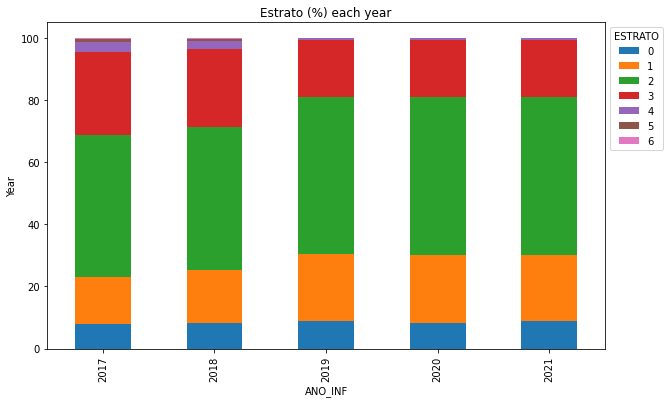

In [17]:
ax = crosstab.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('%')
ax.set_ylabel('Year')
ax.set_title("Estrato (%) each year")
plt.legend(title='ESTRATO', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

## SISBEN

In [18]:
Simat_F["SISBEN"] = Simat_F["SISBEN"].str.replace(",",".").str.replace(" ", "")
Simat_F["SISBEN"] = pd.to_numeric(Simat_F["SISBEN"], errors='coerce')

In [19]:
Simat_F["SISBEN"][Simat_F["ANO_INF"] == 2017].head()

0    0.01
1     NaN
2     NaN
3     NaN
4     NaN
Name: SISBEN, dtype: float64

In [20]:
Simat_F["SISBEN"][Simat_F["ANO_INF"] == 2018].head()

1152808    47.0
1152809    57.0
1152810    57.0
1152811    51.0
1152812     NaN
Name: SISBEN, dtype: float64

In [21]:
Simat_F["SISBEN"][Simat_F["ANO_INF"] == 2021].head()

3605931     0.01
3605932     0.00
3605933    26.58
3605934     0.00
3605935     0.00
Name: SISBEN, dtype: float64

**Observation**: It seems that the coding of "0" was done differently in 2021. While in the other years few students have a score of 0, in 2021 almost half have this score.

**Solution**: Since in 2021 it is not possible to differentiate between an original "0" and a "0" placed as a replacement for empty values, we will just ignore the "0" in all the variables


In [22]:
Simat_F["SISBEN"][Simat_F["SISBEN"] == 0] = np.nan  

<ipython-input-22-105e369657fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Simat_F["SISBEN"][Simat_F["SISBEN"] == 0] = np.nan


In [23]:
Sis2017 = Simat_F["SISBEN"][Simat_F["ANO_INF"] == 2017]
Sis2018 = Simat_F["SISBEN"][Simat_F["ANO_INF"] == 2018]
Sis2019 = Simat_F["SISBEN"][Simat_F["ANO_INF"] == 2019]
Sis2020 = Simat_F["SISBEN"][Simat_F["ANO_INF"] == 2020]
Sis2021 = Simat_F["SISBEN"][Simat_F["ANO_INF"] == 2021]

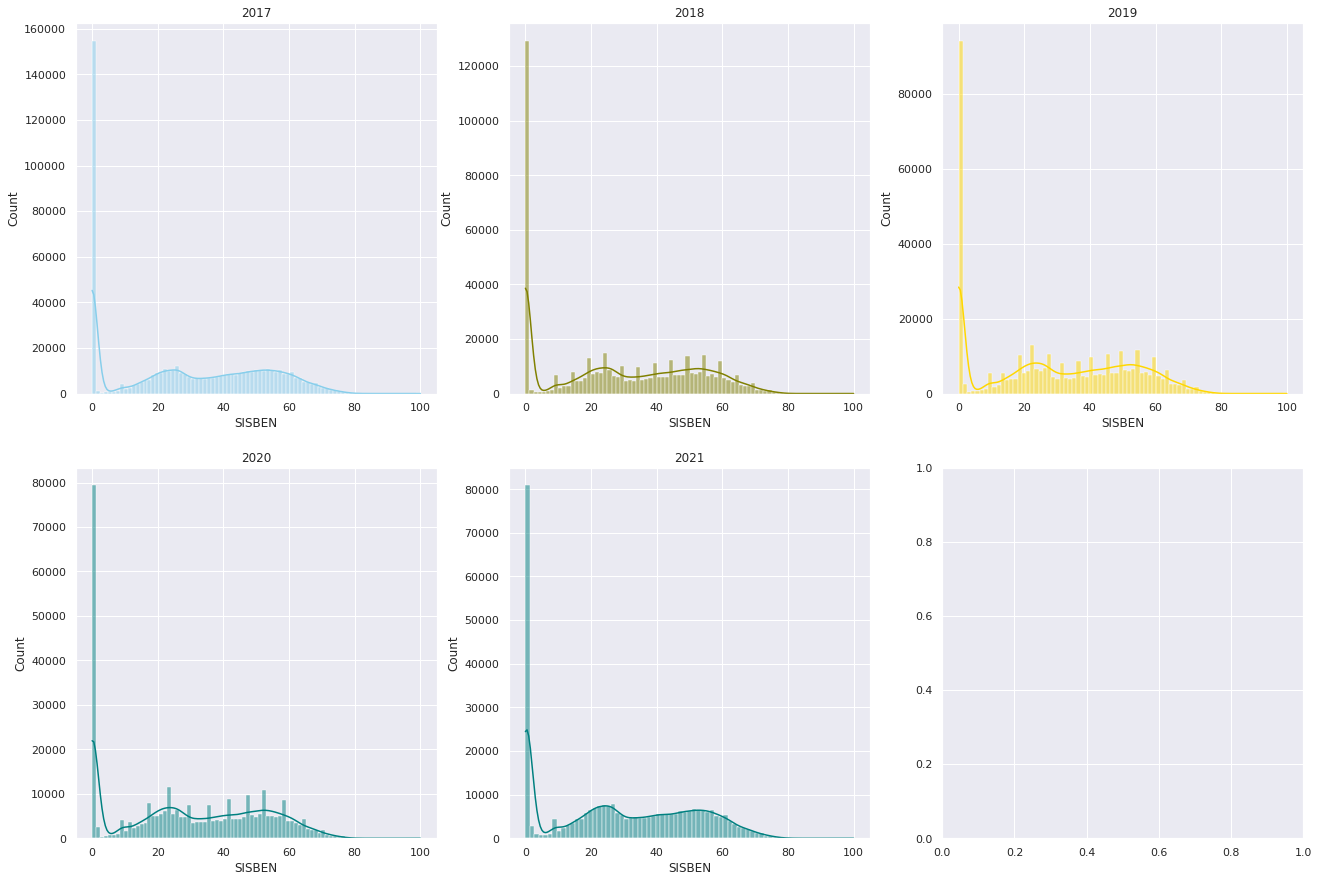

In [24]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(22, 15))

sns.histplot(data=Sis2017, x=Sis2017, kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=Sis2018, x=Sis2018, kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=Sis2019, x=Sis2019, kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data=Sis2020, x=Sis2020, kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data=Sis2021, x=Sis2021, kde=True, color="teal", ax=axs[1, 1])

axs[0, 0].set_title('2017')
axs[0, 1].set_title('2018')
axs[0, 2].set_title('2019')
axs[1, 0].set_title('2020')
axs[1, 1].set_title('2021')


plt.show()

## Data cleaning Part II
### Focusing on Student's origin, disabilities, Etnia and School level.
Now we focus our attention on some other variables and we will see how this are related to the *Repetition Rate*.
First, we do some cleaning on some special variables.

In [3]:
part_2_var = ['PROVIENE_SECTOR_PRIV', 
             'PROVIENE_OTR_MUN',
             'TIPO_DISCAPACIDAD', 
             'CAP_EXC',
             'CODIGO_ETNIA',
             'CODIGO_JORNADA',
             'CARACTER',
             'CODIGO_ESPECIALIDAD',
             'CODIGO_GRADO',
             'REPITENTE',
             'ANO_INF'
             ]

In [7]:
df_part_2 = Simat_F[part_2_var]

In [10]:
df_part_2.head()

,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,REPITENTE,ANO_INF
0,N,N,99,9,0,6,1.0,5,10,N,2017
1,N,N,99,9,0,3,0.0,0,0,N,2017
2,N,N,7,9,0,3,0.0,0,3,N,2017
3,N,N,99,9,0,3,0.0,0,0,N,2017
4,N,N,99,9,0,3,0.0,0,-1,N,2017


First, we see a little bit of the information contained in this variables.

In [30]:
for col in df_part_2:
    print(df_part_2[col].unique() , str(col))

['N', 'S']
Categories (2, object): ['N', 'S'] PROVIENE_SECTOR_PRIV
['N', 'S']
Categories (2, object): ['N', 'S'] PROVIENE_OTR_MUN
[99  7  8 10 18 15 13 11  3  4 19 17 14  6 12  1  2  9  5 16] TIPO_DISCAPACIDAD
[ 9  4  1  3  2  5  6  7 11 10] CAP_EXC
[  0  46  49 200  75  97  19 999  83   1  45  26   4  29  74  53  44  77
  12  34  95  80   9  20  10  42  73  72  99  71  52   7  47 100  27  17
  15  25   5  14  31  66  70  28   2  48 400  22  18   6  57  64   3  65
  13 101  33  32  67   8  35 998  16  50  23  37  56  11  58  51  85  96
  86  62  40  30  54  38  82  90  36  43  21  61  24  92  81  55  68  60
  94 107  69 102  39  59  79  93  84  98 109  76] CODIGO_ETNIA
[6 3 2 4 1 5] CODIGO_JORNADA
[1. 0. 2.] CARACTER
[ 5  0  6  8  9  7 10] CODIGO_ESPECIALIDAD
[10  0  3 -1  9  7 11  8  6  5  2  4  1 99 25 26 23 24 22 -2 21 12 13] CODIGO_GRADO
['N', 'S']
Categories (2, object): ['N', 'S'] REPITENTE
[2017 2018 2019 2020 2021] ANO_INF


In [13]:
df_part_2.dtypes

PROVIENE_SECTOR_PRIV     object
PROVIENE_OTR_MUN         object
TIPO_DISCAPACIDAD         int64
CAP_EXC                   int64
CODIGO_ETNIA              int64
CODIGO_JORNADA            int64
CARACTER                float64
CODIGO_ESPECIALIDAD       int64
CODIGO_GRADO              int64
REPITENTE                object
ANO_INF                   int64
dtype: object

In [14]:
type_obj_2 = ['PROVIENE_SECTOR_PRIV', 'PROVIENE_OTR_MUN', 'REPITENTE']
for name in type_obj_2:
    df_part_2[name] = df_part_2[name].astype('category') 

<ipython-input-14-9cbc063b95a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part_2[name] = df_part_2[name].astype('category')


## School Level (Grade)

In [16]:
Grade_RR_2017 = Simat_F["CODIGO_GRADO"][(Simat_F["ANO_INF"] == 2017) & (df_part_2['REPITENTE']=='S')]
Grade_RR_2018 = Simat_F["CODIGO_GRADO"][(Simat_F["ANO_INF"] == 2018) & (df_part_2['REPITENTE']=='S') ]
Grade_RR_2019 = Simat_F["CODIGO_GRADO"][(Simat_F["ANO_INF"] == 2019) & (df_part_2['REPITENTE']=='S')]
Grade_RR_2020 = Simat_F["CODIGO_GRADO"][(Simat_F["ANO_INF"] == 2020) & (df_part_2['REPITENTE']=='S')]
Grade_RR_2021 = Simat_F["CODIGO_GRADO"][(Simat_F["ANO_INF"] == 2021) & (df_part_2['REPITENTE']=='S')]

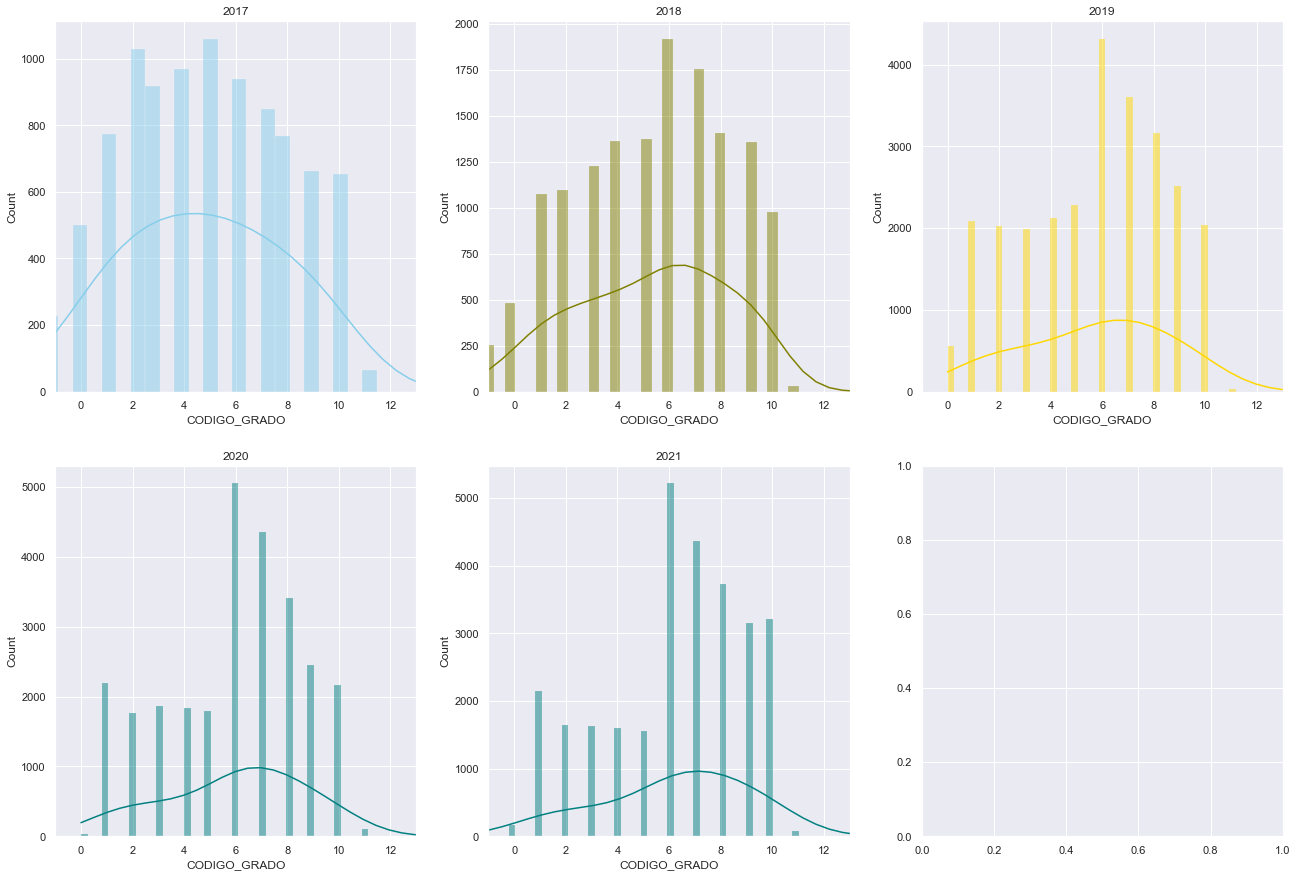

In [22]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(22, 15))

sns.histplot(data= Grade_RR_2017, x= Grade_RR_2017, kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data= Grade_RR_2018, x= Grade_RR_2018, kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data= Grade_RR_2019, x= Grade_RR_2019, kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data= Grade_RR_2020, x= Grade_RR_2020, kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data= Grade_RR_2021, x= Grade_RR_2021, kde=True, color="teal", ax=axs[1, 1])

axs[0, 0].set_title('2017')
axs[0, 1].set_title('2018')
axs[0, 2].set_title('2019')
axs[1, 0].set_title('2020')
axs[1, 1].set_title('2021')

axs[0,0].set(xlim=(-1, 13))
axs[0,1].set(xlim=(-1, 13))
axs[0,2].set(xlim=(-1, 13))
axs[1,0].set(xlim=(-1, 13))
axs[1,1].set(xlim=(-1, 13))

plt.show()

**Observations**: We can see thta across all data sets, the Repititon Rate is concentrated in sixth grade. This is expected as the transition from 'Primary school' to 'Secondary school' is the hardest one.

## Etnia


In [33]:
ETNIA_RR_2017 = Simat_F["CODIGO_ETNIA"][(Simat_F["ANO_INF"] == 2017) & (df_part_2['REPITENTE']=='S')]
ETNIA_RR_2018 = Simat_F["CODIGO_ETNIA"][(Simat_F["ANO_INF"] == 2018) & (df_part_2['REPITENTE']=='S') ]
ETNIA_RR_2019 = Simat_F["CODIGO_ETNIA"][(Simat_F["ANO_INF"] == 2019) & (df_part_2['REPITENTE']=='S')]
ETNIA_RR_2020 = Simat_F["CODIGO_ETNIA"][(Simat_F["ANO_INF"] == 2020) & (df_part_2['REPITENTE']=='S')]
ETNIA_RR_2021 = Simat_F["CODIGO_ETNIA"][(Simat_F["ANO_INF"] == 2021) & (df_part_2['REPITENTE']=='S')]

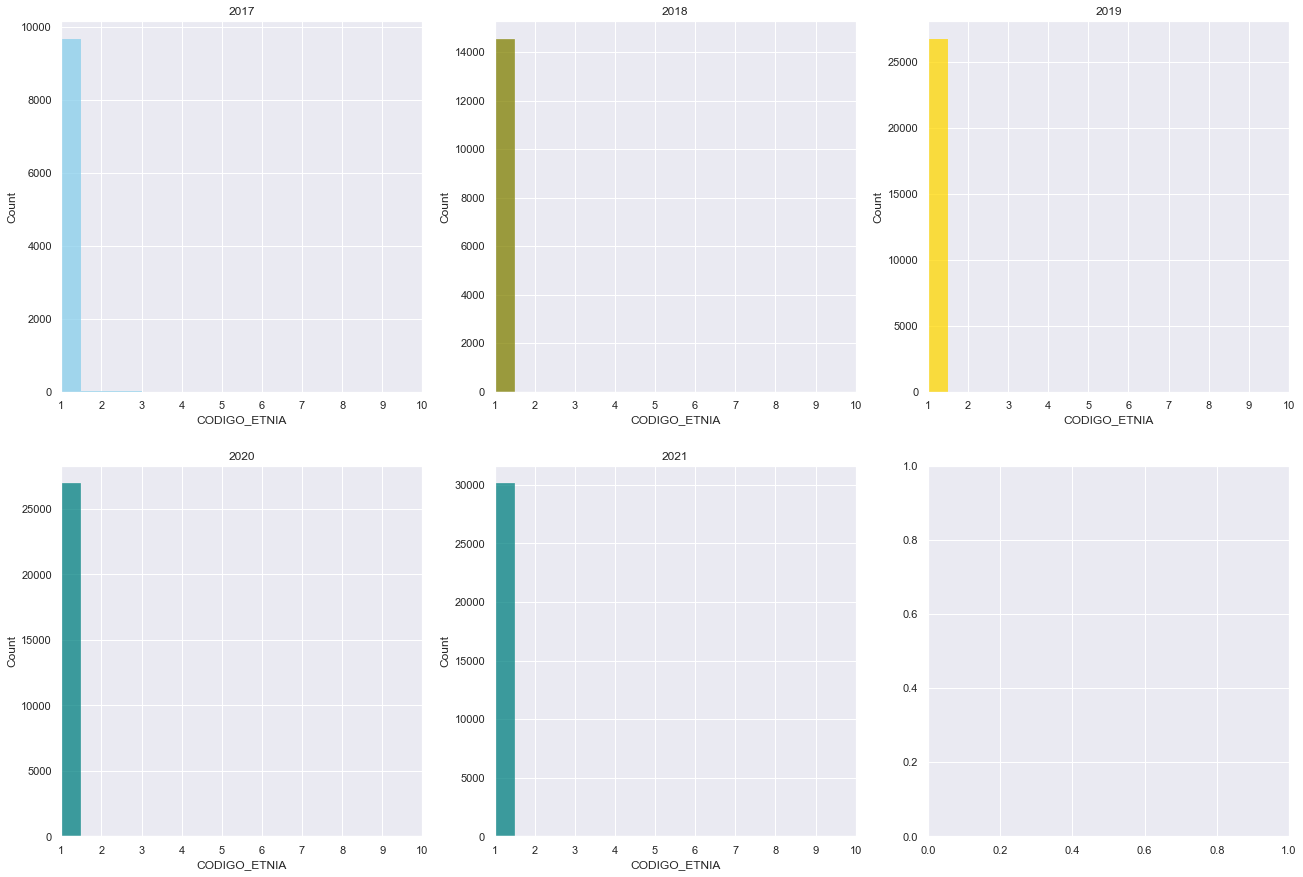

In [51]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(22, 15))

sns.histplot(data= ETNIA_RR_2017, x= ETNIA_RR_2017,  color="skyblue", ax=axs[0, 0], binwidth = 1.5, bins = 30)
sns.histplot(data= ETNIA_RR_2018, x= ETNIA_RR_2018,  color="olive", ax=axs[0, 1] ,  binwidth = 1.5, bins = 30 )
sns.histplot(data= ETNIA_RR_2019, x= ETNIA_RR_2019,  color="gold", ax=axs[0, 2],  binwidth = 1.5, bins = 30)
sns.histplot(data= ETNIA_RR_2020, x= ETNIA_RR_2020, color="teal", ax=axs[1, 0],  binwidth = 1.5, bins = 30)
sns.histplot(data= ETNIA_RR_2021, x= ETNIA_RR_2021, color="teal", ax=axs[1, 1],  binwidth = 1.5, bins = 30)

axs[0, 0].set_title('2017')
axs[0, 1].set_title('2018')
axs[0, 2].set_title('2019')
axs[1, 0].set_title('2020')
axs[1, 1].set_title('2021')


axs[0,0].set(xlim=(1, 10))
axs[0,1].set(xlim=(1, 10))
axs[0,2].set(xlim=(1, 10))
axs[1,0].set(xlim=(1, 10))
axs[1,1].set(xlim=(1, 10))
plt.show()

All students whit Repetition = 'Yes' are from Etnia 1 or zero.